In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags, linalg
import warnings
import time

warnings.filterwarnings("ignore")

In [42]:
D = 1


def u_truth(x, t): return x * (x ** 2 + np.exp(t))
def q_fn(x, t): return x * np.exp(t) - 6 * x
def u0_x_fn(x): return x ** 3 + x
def u0_t_fn(t): return np.zeros_like(t)


def u1_t_fn(t): return 1 + np.exp(t)

# Fisher方程
AA = 1
BB = -AA
m = 2
D = 1
# u_t = D*u_xx+u(AA+BB*u^(m-1))

lamb = AA*(1-m)*(m+3)/(2*(m+1))
mu = (AA*(1-m)**2/(2*(m+1)))**0.5
beta = (-BB/AA)**0.5
def fisher(x, t): return (beta+np.exp(lamb*t+(mu*x)/D**0.5))**(2/(1-m))
def FFF(u): return u*(AA+BB*u**(m-1))
def u_x_ta(x,t=0): return (beta+np.exp(lamb*t+(mu*x)/D**0.5))**(2/(1-m))
def u_xa_t(t,x=0): return (beta+np.exp(lamb*t+(mu*x)/D**0.5))**(2/(1-m))
def u_xb_t(t,x=1): return (beta+np.exp(lamb*t+(mu*x)/D**0.5))**(2/(1-m))

(1001, 1001) (1001, 1001)


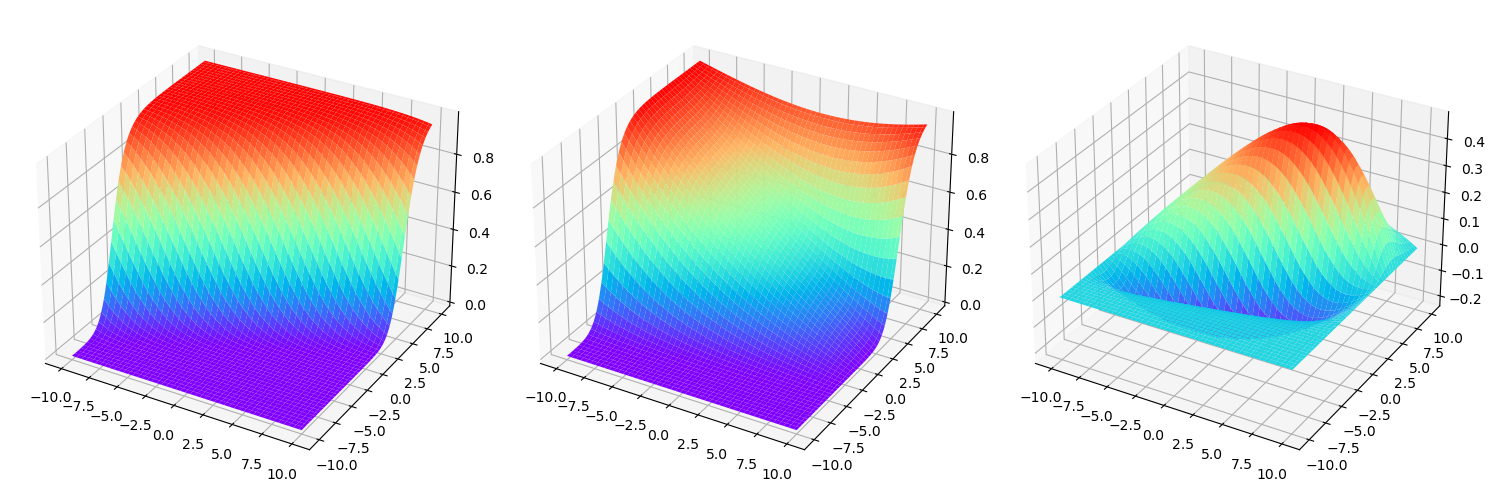

r=1000.0000 4.845954e-01
程序运行时间:1.0300321578979492秒


In [43]:
def cn(a, b, Nx, Nt):
    xx = np.linspace(a, b, Nx + 1, endpoint=True)
    h = 1 / Nx
    tt = np.linspace(a, b, Nt + 1, endpoint=True)
    tau = 1 / Nt

    sol = np.zeros([Nx + 1, Nt + 1])

    sol[:, 0] = u_x_ta(x=xx,t=a)
    sol[0, 1:] = u_xa_t(t=tt[1:],x=a)
    sol[-1, 1:] = u_xb_t(t=tt[1:],x=b)

    xx_mesh, tt_mesh = np.meshgrid(xx, tt)
    gg = fisher(x=xx_mesh, t=tt_mesh)
    r = D * tau / h / h

    # f(u)差分1
    A = diags([[-r / 2] * (Nx - 2), [1 + r] * (Nx - 1),
              [-r / 2] * (Nx - 2)], [-1, 0, 1])
    B = diags([[r / 2] * (Nx - 2), [1 - r] * (Nx - 1),
              [r / 2] * (Nx - 2)], [-1, 0, 1])
    for t_idx in range(Nt):
        _f = np.zeros(Nx - 1)
        _f = _f + tau * FFF(u=sol[1:-1, t_idx])
        _f[0] += r / 2 * (sol[0, t_idx + 1] + sol[0, t_idx])
        _f[-1] += r / 2 * (sol[-1, t_idx + 1] + sol[-1, t_idx])
        sol[1:-1, t_idx + 1] = linalg.spsolve(A, B * sol[1:-1, t_idx] + _f)

    # f(u)差分2
    # A = diags([[-r / 2] * (Nx ), [1 + r] * (Nx + 1),
    #           [-r / 2] * (Nx )], [-1, 0, 1])
    # B = diags([[r / 2] * (Nx), [1 - r] * (Nx + 1),
    #           [r / 2] * (Nx)], [-1, 0, 1])
    # Nt_2 = diags([tau / 2]*(Nx + 1))
    # for t_idx in range(Nt):
    #     _f = sol[:, t_idx]
    #     __f = _f.copy()
    #     for iii in range(10):
    #         delta = linalg.inv(A-diags(tau/2*(1-2*__f)))*((A-Nt_2)*__f-(B+Nt_2)*_f)
    #         __f = __f - delta
    #     sol[1:-1, t_idx+1] = __f[1:-1]

    # f(u)差分3
    # A = diags([[-r / 2] * (Nx - 2), [1 + r] * (Nx - 1),
    #           [-r / 2] * (Nx - 2)], [-1, 0, 1])
    # B = diags([[r / 2] * (Nx - 2), [1 - r] * (Nx - 1),
    #           [r / 2] * (Nx - 2)], [-1, 0, 1])
    # for t_idx in range(Nt):
    #     _f = np.zeros(Nx - 1)
    #     _f = sol[1:-1,t_idx]
    #     sol[1:-1, t_idx + 1] = linalg.spsolve(A, B * sol[1:-1, t_idx] + _f)

    print(gg.shape,sol.shape)
    fig=plt.figure(figsize=(15, 5))
    fig.set_tight_layout(True)
    ax = fig.add_subplot(131, projection='3d')
    ax.plot_surface(xx_mesh, tt_mesh, gg, cmap="rainbow")
    ax = fig.add_subplot(132, projection='3d')
    ax.plot_surface(xx_mesh, tt_mesh, sol.T, cmap="rainbow")
    ax = fig.add_subplot(133, projection='3d')
    ax.plot_surface(xx_mesh, tt_mesh, gg-sol.T, cmap="rainbow")
    plt.show()
    print(f"r={r:.4f}", f"{np.max(np.abs(gg - sol.T)):.6e}")


T1 = time.time()
cn(-10, 10, 1000, 1000)
T2 = time.time()
print('程序运行时间:%s秒' % (T2 - T1))


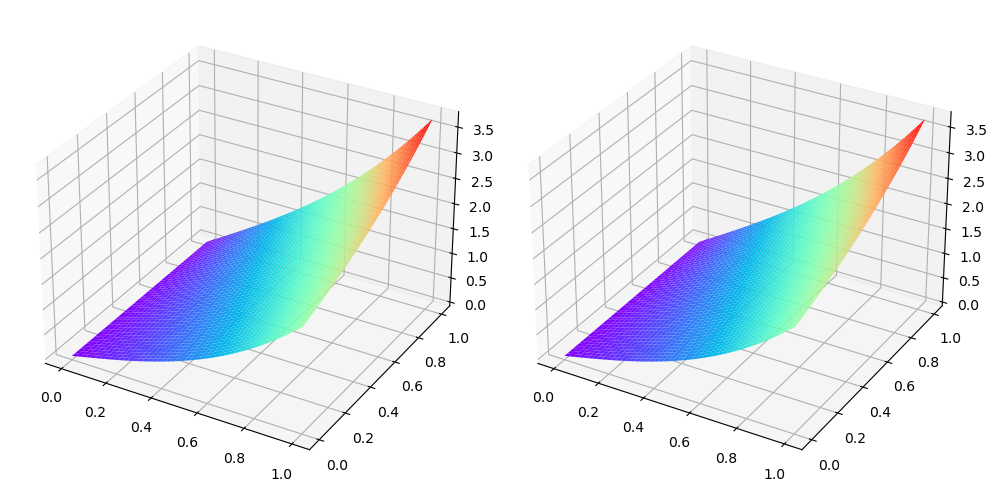

r=100.0000 7.857581e-11
程序运行时间:4.320218563079834秒


In [75]:
def cn(a,b,Nx, Nt):
    xx = np.linspace(a, b, Nx + 1, endpoint=True)
    h = 1 / Nx
    tt = np.linspace(a, b, Nt + 1, endpoint=True)
    tau = 1 / Nt

    sol = np.zeros([Nt + 1, Nx + 1])

    # initialization
    sol[0, :] = u0_x_fn(x=xx)
    r = D * tau / h / h
    A = diags([[-r / 2] * (Nx - 2), [1 + r] * (Nx - 1), [-r / 2] * (Nx - 2)], [-1, 0, 1])
    B = diags([[r / 2] * (Nx - 2), [1 - r] * (Nx - 1), [r / 2] * (Nx - 2)], [-1, 0, 1])
    for t_idx in range(Nt):
        sol[t_idx + 1, 0] = u_truth(x=xx[0],t=tt[t_idx+1])
        sol[t_idx + 1, -1] = u_truth(x=xx[-1],t=tt[t_idx+1])
        _f = np.zeros(Nx - 1)
        _f[0] = r / 2 * (sol[t_idx + 1, 0] + sol[t_idx, 0])
        _f[-1] = r / 2 * (sol[t_idx + 1, Nx] + sol[t_idx, Nx])
        _f = _f + tau * q_fn(x=xx[1:-1], t=tt[t_idx] + tau / 2)
        sol[t_idx + 1, 1:-1] = linalg.spsolve(A, B * sol[t_idx, 1:-1] + _f)

    xx_mesh, tt_mesh = np.meshgrid(xx, tt)
    gg = u_truth(x=xx_mesh, t=tt_mesh)
    fig=plt.figure(figsize=(10, 5))
    fig.set_tight_layout(True)
    ax = fig.add_subplot(121, projection='3d')
#     ax.contourf(xx_mesh, tt_mesh, gg, vmin=0, vmax=4, levels=100)
    ax.plot_surface(xx_mesh, tt_mesh, gg, cmap="rainbow")
    ax = fig.add_subplot(122, projection='3d')
#     ax.contourf(xx_mesh, tt_mesh, sol, vmin=0, vmax=4, levels=100)
    ax.plot_surface(xx_mesh, tt_mesh, sol, cmap="rainbow")
    # ax[2].contourf(xx_mesh, tt_mesh, np.abs(gg - sol), vmin=0, vmax=4)
    plt.show()
    print(f"r={r:.4f}", f"{np.max(np.abs(gg - sol)):.6e}")
    
T1 = time.time()
cn(0, 1, 1000, 10000)
T2 = time.time()
print('程序运行时间:%s秒' % (T2 - T1))

In [73]:
Nx = 10
h = 1 / Nx
Nn = 0.1  # 重叠区域大小
n = int(Nn/h)  # 重叠区域格子数
a = 0
x_1R = 0.2
x_0L = x_1R+Nn
b = 1
x_0Len = int((x_0L-a)/h)
x_1Len = int((b-x_1R)/h)
xx_0 = np.linspace(a, x_0L, x_0Len+1, endpoint=True)
xx_1 = np.linspace(x_1R, b, x_1Len+1, endpoint=True)

Nt = 1000
tau = 1 / Nt
tt = np.linspace(a, b, Nt + 1, endpoint=True)

sol_0 = np.zeros([Nt+1, x_0Len+1])
sol_1 = np.zeros([Nt+1, x_1Len+1])

r = D * tau / h ** 2
sol_0[0, :] = u0_x_fn(x=xx_0)
sol_0[1:, 0] = u_truth(x=xx_0[0], t=tt[1:])
sol_0[1:, -1] = sol_0[0, -1]
# sol_0[1:, -1] = 0
A_0 = diags([[-r / 2] * (x_0Len - 2), [1 + r] * (x_0Len - 1),
            [-r / 2] * (x_0Len - 2)], [-1, 0, 1])
B_0 = diags([[r / 2] * (x_0Len - 2), [1 - r] * (x_0Len - 1),
            [r / 2] * (x_0Len - 2)], [-1, 0, 1])
sol_1[0, :] = u0_x_fn(x=xx_1)
sol_1[1:, 0] = sol_1[0, 0]
# sol_1[1:, 0] = 0
sol_1[1:, -1] = u_truth(x=xx_1[-1], t=tt[1:])
A_1 = diags([[-r / 2] * (x_1Len - 2), [1 + r] * (x_1Len - 1),
            [-r / 2] * (x_1Len - 2)], [-1, 0, 1])
B_1 = diags([[r / 2] * (x_1Len - 2), [1 - r] * (x_1Len - 1),
            [r / 2] * (x_1Len - 2)], [-1, 0, 1])

T1 = time.time()
for ji in range(100):
    for t_idx in range(Nt):
        _f = np.zeros(x_0Len - 1)
        _f[0] = r / 2 * (sol_0[t_idx + 1, 0] + sol_0[t_idx, 0])
        _f[-1] = r / 2 * (sol_0[t_idx + 1, -1] + sol_0[t_idx, -1])
        _f = _f + tau * q_fn(x=xx_0[1:-1], t=tt[t_idx] + tau / 2)
        sol_0[t_idx + 1, 1:-
              1] = linalg.spsolve(A_0, B_0 * sol_0[t_idx, 1:-1] + _f)
    for t_idx in range(Nt):
        _f = np.zeros(x_1Len - 1)
        _f[0] = r / 2 * (sol_1[t_idx + 1, 0] + sol_1[t_idx, 0])
        _f[-1] = r / 2 * (sol_1[t_idx + 1, -1] + sol_1[t_idx, -1])
        _f = _f + tau * q_fn(x=xx_1[1:-1], t=tt[t_idx] + tau / 2)
        sol_1[t_idx + 1, 1:-1] = linalg.spsolve(A_1, B_1 * sol_1[t_idx, 1:-1] + _f)

    xx_0_mesh, tt_0_mesh = np.meshgrid(xx_0, tt)
    gg_0 = u_truth(x=xx_0_mesh, t=tt_0_mesh)
    xx_1_mesh, tt_1_mesh = np.meshgrid(xx_1, tt)
    gg_1 = u_truth(x=xx_1_mesh, t=tt_1_mesh)
    print(ji, f"r0={r:.4f}", f"{np.max(np.abs(gg_0 - sol_0)):.6e}",
          f"r1={r:.4f}", f"{np.max(np.abs(gg_1 - sol_1)):.6e}")

    if max(np.max(np.abs(gg_0 - sol_0)), np.max(np.abs(gg_1 - sol_1))) < 7e-9:
        break

    sol_0[:, x_0Len] = sol_1[:, n]
    sol_1[:, 0] = sol_0[:, x_0Len-n]

T2 = time.time()
print('程序运行时间:%s秒' % (T2 - T1))


0 r0=0.1000 5.154845e-01 r1=0.1000 3.436564e-01
1 r0=0.1000 2.893780e-01 r1=0.1000 3.391678e-01
2 r0=0.1000 2.855439e-01 r1=0.1000 1.903626e-01
3 r0=0.1000 1.601736e-01 r1=0.1000 1.878277e-01
4 r0=0.1000 1.580083e-01 r1=0.1000 1.053389e-01
5 r0=0.1000 8.856066e-02 r1=0.1000 1.039073e-01
6 r0=0.1000 8.733783e-02 r1=0.1000 5.822522e-02
7 r0=0.1000 4.890786e-02 r1=0.1000 5.741673e-02
8 r0=0.1000 4.821726e-02 r1=0.1000 3.214484e-02
9 r0=0.1000 2.697511e-02 r1=0.1000 3.168825e-02
10 r0=0.1000 2.658510e-02 r1=0.1000 1.772340e-02
11 r0=0.1000 1.485761e-02 r1=0.1000 1.746554e-02
12 r0=0.1000 1.463735e-02 r1=0.1000 9.758235e-03
13 r0=0.1000 8.171179e-03 r1=0.1000 9.612612e-03
14 r0=0.1000 8.046795e-03 r1=0.1000 5.364530e-03
15 r0=0.1000 4.486564e-03 r1=0.1000 5.282292e-03
16 r0=0.1000 4.416322e-03 r1=0.1000 2.944215e-03
17 r0=0.1000 2.459079e-03 r1=0.1000 2.897774e-03
18 r0=0.1000 2.419415e-03 r1=0.1000 1.612944e-03
19 r0=0.1000 1.345209e-03 r1=0.1000 1.586720e-03
20 r0=0.1000 1.322813e-03 r1=0

In [5]:
Nx = 1000
h = 1 / Nx
Nn = 0.3  # 重叠区域大小
n = int(Nn/h)  # 重叠区域格子数
x_0L = 0
x_0R = 0.4
x_1L = x_0R-Nn
x_1R = 0.8
x_2L = x_1R-Nn
x_2R = 1
x_0Len = int((x_0R-x_0L)/h)
x_1Len = int((x_1R-x_1L)/h)
x_2Len = int((x_2R-x_2L)/h)
xx_0 = np.linspace(x_0L, x_0R, x_0Len+1, endpoint=True)
xx_1 = np.linspace(x_1L, x_1R, x_1Len+1, endpoint=True)
xx_2 = np.linspace(x_2L, x_2R, x_2Len+1, endpoint=True)

Nt = 10000
tau = 1 / Nt
tt = np.linspace(0, 1, Nt + 1, endpoint=True)

sol_0 = np.zeros([Nt+1, x_0Len+1])
sol_1 = np.zeros([Nt+1, x_1Len+1])
sol_2 = np.zeros([Nt+1, x_2Len+1])

r = D * tau / h ** 2
sol_0[0, :] = u0_x_fn(x=xx_0)
sol_0[1:, 0] = u_truth(x=xx_0[0], t=tt[1:])
sol_0[1:, -1] = 0
A_0 = diags([[-r / 2] * (x_0Len - 2), [1 + r] * (x_0Len - 1),
            [-r / 2] * (x_0Len - 2)], [-1, 0, 1])
B_0 = diags([[r / 2] * (x_0Len - 2), [1 - r] * (x_0Len - 1),
            [r / 2] * (x_0Len - 2)], [-1, 0, 1])
sol_1[0, :] = u0_x_fn(x=xx_1)
sol_1[1:, 0] = 0
sol_1[1:, -1] = 0
A_1 = diags([[-r / 2] * (x_1Len - 2), [1 + r] * (x_1Len - 1),
            [-r / 2] * (x_1Len - 2)], [-1, 0, 1])
B_1 = diags([[r / 2] * (x_1Len - 2), [1 - r] * (x_1Len - 1),
            [r / 2] * (x_1Len - 2)], [-1, 0, 1])
sol_2[0, :] = u0_x_fn(x=xx_2)
sol_2[1:, 0] = 0
sol_2[1:, -1] = u_truth(x=xx_2[-1], t=tt[1:])
A_2 = diags([[-r / 2] * (x_2Len - 2), [1 + r] * (x_2Len - 1),
            [-r / 2] * (x_2Len - 2)], [-1, 0, 1])
B_2 = diags([[r / 2] * (x_2Len - 2), [1 - r] * (x_2Len - 1),
            [r / 2] * (x_2Len - 2)], [-1, 0, 1])
for ij in range(100):
    t1=time.time()
    for t_idx in range(Nt):
        _f = np.zeros(x_0Len - 1)
        _f[0] = r / 2 * (sol_0[t_idx + 1, 0] + sol_0[t_idx, 0])
        _f[-1] = r / 2 * (sol_0[t_idx + 1, -1] + sol_0[t_idx, -1])
        _f = _f + tau * q_fn(x=xx_0[1:-1], t=tt[t_idx] + tau / 2)
        sol_0[t_idx + 1, 1:-1] = linalg.spsolve(A_0, B_0 * sol_0[t_idx, 1:-1] + _f)
    for t_idx in range(Nt):
        _f = np.zeros(x_1Len - 1)
        _f[0] = r / 2 * (sol_1[t_idx + 1, 0] + sol_1[t_idx, 0])
        _f[-1] = r / 2 * (sol_1[t_idx + 1, -1] + sol_1[t_idx, -1])
        _f = _f + tau * q_fn(x=xx_1[1:-1], t=tt[t_idx] + tau / 2)
        sol_1[t_idx + 1, 1:-1] = linalg.spsolve(A_1, B_1 * sol_1[t_idx, 1:-1] + _f)
    for t_idx in range(Nt):
        _f = np.zeros(x_2Len - 1)
        _f[0] = r / 2 * (sol_2[t_idx + 1, 0] + sol_2[t_idx, 0])
        _f[-1] = r / 2 * (sol_2[t_idx + 1, -1] + sol_2[t_idx, -1])
        _f = _f + tau * q_fn(x=xx_2[1:-1], t=tt[t_idx] + tau / 2)
        sol_2[t_idx + 1, 1:-1] = linalg.spsolve(A_2, B_2 * sol_2[t_idx, 1:-1] + _f)

    xx_0_mesh, tt_0_mesh = np.meshgrid(xx_0, tt)
    gg_0 = u_truth(x=xx_0_mesh, t=tt_0_mesh)
    xx_1_mesh, tt_1_mesh = np.meshgrid(xx_1, tt)
    gg_1 = u_truth(x=xx_1_mesh, t=tt_1_mesh)
    xx_2_mesh, tt_2_mesh = np.meshgrid(xx_2, tt)
    gg_2 = u_truth(x=xx_2_mesh, t=tt_2_mesh)
    print(ij,f"r0={r:.4f}", f"{np.max(np.abs(gg_0 - sol_0)):.6e}",
        f"r1={r:.4f}", f"{np.max(np.abs(gg_1 - sol_1)):.6e}",
        f"r2={r:.4f}", f"{np.max(np.abs(gg_2 - sol_2)):.6e}",)
    # if max(np.max(np.abs(gg_0 - sol_0)), np.max(np.abs(gg_1 - sol_1)),np.max(np.abs(gg_2 - sol_2))) < 7e-9:
    #     break
    print(time.time()-t1)
    sol_0[1:, -1] = sol_1[1:, n]
    sol_1[1:, 0] = sol_0[1:, x_0Len-n]
    sol_1[1:, -1] = sol_2[1:, n]
    sol_2[1:, 0] = sol_1[1:, x_1Len-n]


0 r0=100.0000 1.151313e+00 r1=100.0000 2.686625e+00 r2=100.0000 1.484141e+00
6.456355333328247
1 r0=100.0000 1.239950e+00 r1=100.0000 5.751323e-01 r2=100.0000 1.579344e+00
6.39226770401001
2 r0=100.0000 3.833613e-01 r1=100.0000 6.141994e-01 r2=100.0000 4.271006e-01
6.390441179275513
3 r0=100.0000 4.142572e-01 r1=100.0000 1.654996e-01 r2=100.0000 4.603652e-01
6.395068883895874
4 r0=100.0000 1.160045e-01 r1=100.0000 1.791010e-01 r2=100.0000 1.288232e-01
6.349998950958252
5 r0=100.0000 1.266945e-01 r1=100.0000 4.992482e-02 r2=100.0000 1.403378e-01
6.342392921447754
6 r0=100.0000 3.378339e-02 r1=100.0000 5.461918e-02 r2=100.0000 3.961195e-02
6.332367420196533
7 r0=100.0000 3.745590e-02 r1=100.0000 1.535139e-02 r2=100.0000 4.356850e-02
6.450430870056152
8 r0=100.0000 8.875762e-03 r1=100.0000 1.696024e-02 r2=100.0000 1.269023e-02
6.38879656791687
9 r0=100.0000 1.012833e-02 r1=100.0000 4.915273e-03 r2=100.0000 1.403992e-02
6.400756359100342
10 r0=100.0000 1.340825e-03 r1=100.0000 5.462312e-03

In [ ]:
for t_idx in range(Nt):
    _f = np.zeros(x_0Len - 1)
    _f[0] = r / 2 * (sol_0[t_idx + 1, 0] + sol_0[t_idx, 0])
    _f[-1] = r / 2 * (sol_0[t_idx + 1, -1] + sol_0[t_idx, -1])
    _f = _f + tau * q_fn(x=xx_0[1:-1], t=tt[t_idx] + tau / 2)
    sol_0[t_idx + 1, 1:-1] = linalg.spsolve(A_0, B_0 * sol_0[t_idx, 1:-1] + _f)
for t_idx in range(Nt):
    _f = np.zeros(x_1Len - 1)
    _f[0] = r / 2 * (sol_1[t_idx + 1, 0] + sol_1[t_idx, 0])
    _f[-1] = r / 2 * (sol_1[t_idx + 1, -1] + sol_1[t_idx, -1])
    _f = _f + tau * q_fn(x=xx_1[1:-1], t=tt[t_idx] + tau / 2)
    sol_1[t_idx + 1, 1:-1] = linalg.spsolve(A_1, B_1 * sol_1[t_idx, 1:-1] + _f)

    
xx_0_mesh, tt_0_mesh = np.meshgrid(xx_0, tt)
gg = u_truth(x=xx_0_mesh, t=tt_0_mesh)
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
fig.set_tight_layout(True)
ax[0].contourf(xx_0_mesh, tt_0_mesh, gg, vmin=0, vmax=4, levels=100)
ax[1].contourf(xx_0_mesh, tt_0_mesh, sol_0, vmin=0, vmax=4, levels=100)
plt.show()

xx_1_mesh, tt_1_mesh = np.meshgrid(xx_1, tt)
gg = u_truth(x=xx_1_mesh, t=tt_1_mesh)
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
fig.set_tight_layout(True)
ax[0].contourf(xx_1_mesh, tt_1_mesh, gg, vmin=0, vmax=4, levels=100)
ax[1].contourf(xx_1_mesh, tt_1_mesh, sol_1, vmin=0, vmax=4, levels=100)
plt.show()


sol_0[:, x_0Len]=sol_1[:, Nn]
sol_1[:, 0]=sol_0[:,x_0Len-Nn]

![Fisher方程解析解.png](Fisher方程解析解.png)

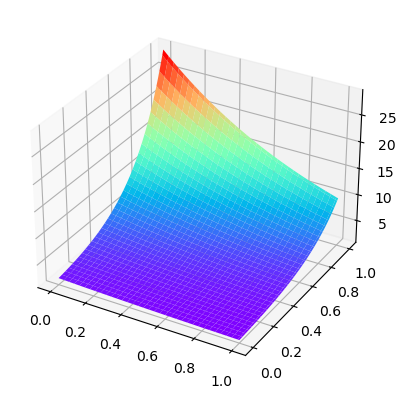

In [3]:
import math
a = 2
b = -2
m = 2
D = 1
# u_t=D*u_xx+u(a+b*u^(m-1))

lamb = a*(1-m)*(m+3)/(2*(m+1))
mu = math.sqrt(a*(1-m)**2/(2*(m+1)))
beta = math.sqrt(-b/a)
def fisher(x, t): return beta+np.exp(lamb*t+(mu*x)/math.sqrt(D))**(2/(1-m))


Nx = 100
Nt = 100
xx = np.linspace(0, 1, Nx + 1, endpoint=True)
h = 1 / Nx
tt = np.linspace(0, 1, Nt + 1, endpoint=True)
tau = 1 / Nt

xx_mesh, tt_mesh = np.meshgrid(xx, tt)
gg = fisher(x=xx_mesh, t=tt_mesh)

fig = plt.figure()  # 定义新的三维坐标轴
ax = plt.axes(projection='3d')
ax.plot_surface(xx_mesh, tt_mesh, gg, cmap='rainbow')
# ax.contourf(xx_mesh, tt_mesh, gg, vmin=0, vmax=4, levels=100)
plt.show()


In [ ]:
def euler(a, b, Nx, Nt):
    xx = np.linspace(a, b, Nx + 1, endpoint=True)
    h = 1 / Nx
    tt = np.linspace(a, b, Nt + 1, endpoint=True)
    tau = 1 / Nt
    sol = np.zeros([Nt + 1, Nx + 1])

    # initialization
    sol[0, :] = u_truth(x=xx,t=tt[0])
    r = D * tau / h / h
    if r>1:
        print("r = {} is larger than 1".format(r))
        return

    for t_idx in range(Nt):
        sol[t_idx + 1, 0] = u_truth(x=xx[0],t=tt[t_idx+1])
        sol[t_idx + 1, -1] = u_truth(x=xx[-1],t=tt[t_idx+1])
        sol[t_idx + 1, 1:-1] = r * sol[t_idx, :-2] + (1 - 2 * r) * sol[t_idx, 1:-1] + r * sol[t_idx, 2:] + tau * q_fn(t=tt[t_idx], x=xx[1:-1])

    xx_mesh, tt_mesh = np.meshgrid(xx, tt)
    gg = u_truth(x=xx_mesh, t=tt_mesh)
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    fig.set_tight_layout(True)
    ax[0].contourf(xx_mesh, tt_mesh, gg, vmin=0, vmax=4, levels=100)
    ax[1].contourf(xx_mesh, tt_mesh, sol, vmin=0, vmax=4, levels=100)
    # ax[2].contourf(xx_mesh, tt_mesh, np.abs(gg - sol), vmin=0, vmax=0.1)
    plt.show()
    print(f"r={r:.4f}", f"{np.max(np.abs(gg - sol)):.6e}")


euler(0, 1, 5, 100)

In [ ]:
def heun(Nx, Nt):
    xx = np.linspace(0, 1, Nx + 1, endpoint=True)
    h = 1 / Nx
    tt = np.linspace(0, 1, Nt + 1, endpoint=True)
    tau = 1 / Nt

    sol = np.zeros([Nt + 1, Nx + 1])

    # initialization
    sol[0, :] = u0_x_fn(x=xx)
    r = a * tau / h / h
    if r>1:
        print("r = {} is larger than 1".format(r))
        return


    for t_idx in range(Nt):
        sol[t_idx + 1, 0] = u0_t_fn(t=tt[t_idx + 1])
        sol[t_idx + 1, Nx] = u1_t_fn(t=tt[t_idx + 1])
        bar_sol = np.zeros(Nx + 1)
        bar_sol[0] = sol[t_idx + 1, 0]
        bar_sol[Nx] = sol[t_idx + 1, Nx]
        bar_sol[1:-1] = r * sol[t_idx, :-2] + (1 - 2 * r) * sol[t_idx, 1:-1] + r * sol[t_idx, 2:] + tau * q_fn(
            t=tt[t_idx], x=xx[1:-1])
        sol[t_idx + 1, 1:-1] = sol[t_idx, 1:-1] + r * (sol[t_idx, 2:] + bar_sol[2:]) / 2 \
                               - r * (sol[t_idx, 1:-1] + bar_sol[1:-1]) \
                               + r * (sol[t_idx, :-2] + bar_sol[:-2]) / 2 \
                               + tau * q_fn(t=(tt[t_idx] + tt[t_idx + 1]) / 2, x=xx[1:-1])

    xx_mesh, tt_mesh = np.meshgrid(xx, tt)
    gg = u_truth(x=xx_mesh, t=tt_mesh)
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    fig.set_tight_layout(True)
    ax[0].contourf(xx_mesh, tt_mesh, gg, vmin=0, vmax=4, levels=100)
    ax[1].contourf(xx_mesh, tt_mesh, sol, vmin=0, vmax=4, levels=100)
    plt.show()
    print(f"r={r:.4f}", f"{np.max(np.abs(gg - sol)):.6e}")

heun(10,1000)